# Spam Classification - Final Notebook
By - Group 7
Team members – 1) Nitish Bhardwaj
               2) Vijay Agarwal
               3) Bashir Ali




In [3]:

# 1) Imports and settings
import warnings
warnings.filterwarnings('ignore')

import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# optional xgboost
try:
    from xgboost import XGBClassifier
    _HAS_XGB = True
except Exception:
    _HAS_XGB = False

# SMOTE
try:
    from imblearn.over_sampling import SMOTE
    _HAS_SMOTE = True
except Exception:
    _HAS_SMOTE = False

sns.set(style='whitegrid')
RANDOM_STATE = 42
DATA_DIR = Path('data')
MODELS_DIR = Path('models')
DATA_DIR.mkdir(exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)


In [4]:

# 2) Download and load dataset from UCI
import urllib.request, zipfile

DATA_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
zip_path = DATA_DIR / 'smsspamcollection.zip'
txt_path = DATA_DIR / 'SMSSpamCollection'

if not txt_path.exists():
    print('Downloading dataset...')
    with urllib.request.urlopen(DATA_URL) as r:
        open(zip_path, 'wb').write(r.read())
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(path=DATA_DIR)
    print('Downloaded and extracted.')

df = pd.read_csv(txt_path, sep='\t', header=None, names=['label','message'], encoding='latin-1')
print('Dataset shape:', df.shape)
df.head()


Dataset shape: (5572, 2)


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


label
ham     4825
spam     747
Name: count, dtype: int64


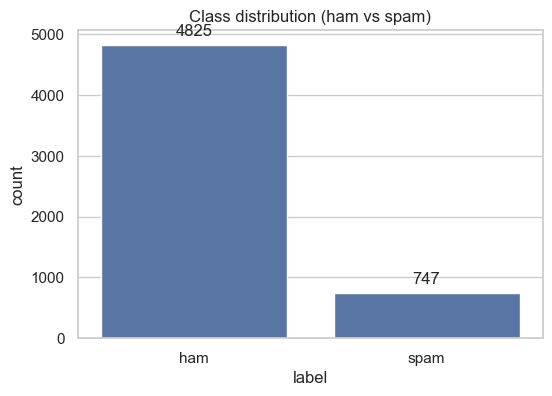

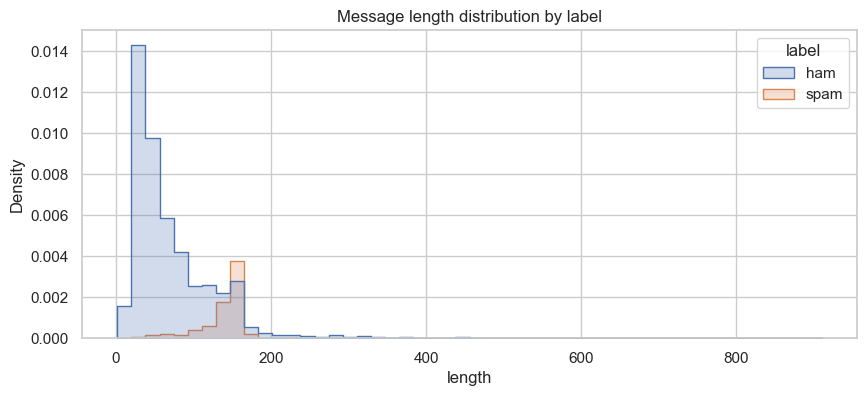

In [5]:

# 3) Basic EDA: class imbalance and message length
print(df['label'].value_counts())
plt.figure(figsize=(6,4))
ax = sns.countplot(x='label', data=df)
for p in ax.patches:
    ax.annotate(int(p.get_height()),  # convert to int
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points')
plt.title('Class distribution (ham vs spam)')
plt.show()

df['length'] = df['message'].str.len()
plt.figure(figsize=(10,4))
sns.histplot(data=df, x='length', hue='label', bins=50, element='step', stat='density')
plt.title('Message length distribution by label')
plt.show()


In [6]:

# 4) Label encoding: ham -> 0, spam -> 1
le = LabelEncoder()
df['label_num'] = le.fit_transform(df['label'])
print('Label mapping:', dict(zip(le.classes_, le.transform(le.classes_))))


Label mapping: {'ham': 0, 'spam': 1}


In [7]:

# 5) Text preprocessing (lowercase, remove punctuation, stopwords, lemmatize)
import re, string
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and t.isalpha()]
    return ' '.join(tokens)

df['clean'] = df['message'].apply(preprocess_text)
df.head()


,label,message,length,label_num,clean
0,ham,"Go until jurong point, crazy.. Available only ...",111,0,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,29,0,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,1,free entry wkly comp win fa cup final tkts may...
3,ham,U dun say so early hor... U c already then say...,49,0,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,0,nah think go usf life around though


In [8]:

# 6) Train-test split (stratified)
from sklearn.model_selection import train_test_split
X = df['clean']
y = df['label_num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


Train shape: (4457,) Test shape: (1115,)


In [9]:

# 7) Feature extraction: TF-IDF, TruncatedSVD (dense components), KMeans cluster feature
tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
print('TF-IDF shape:', X_train_tfidf.shape)

# TruncatedSVD on TF-IDF to get dense components
svd_n = 50
svd = TruncatedSVD(n_components=svd_n, random_state=RANDOM_STATE)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_test_svd = svd.transform(X_test_tfidf)
print('SVD shapes:', X_train_svd.shape, X_test_svd.shape)

# KMeans on SVD components
k_clusters = 6
kmeans = KMeans(n_clusters=k_clusters, random_state=RANDOM_STATE)
cluster_train = kmeans.fit_predict(X_train_svd)
cluster_test = kmeans.predict(X_test_svd)

# One-hot encode clusters
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cluster_train_oh = enc.fit_transform(cluster_train.reshape(-1,1))
cluster_test_oh = enc.transform(cluster_test.reshape(-1,1))

# Message length feature
len_train = np.array([len(t) for t in X_train]).reshape(-1,1)
len_test = np.array([len(t) for t in X_test]).reshape(-1,1)

# Final feature arrays: concatenate SVD components + cluster one-hot + length
X_train_feats = np.hstack([X_train_svd, cluster_train_oh, len_train])
X_test_feats = np.hstack([X_test_svd, cluster_test_oh, len_test])
print('Final feature shapes:', X_train_feats.shape, X_test_feats.shape)


TF-IDF shape: (4457, 2000)
SVD shapes: (4457, 50) (1115, 50)
Final feature shapes: (4457, 57) (1115, 57)


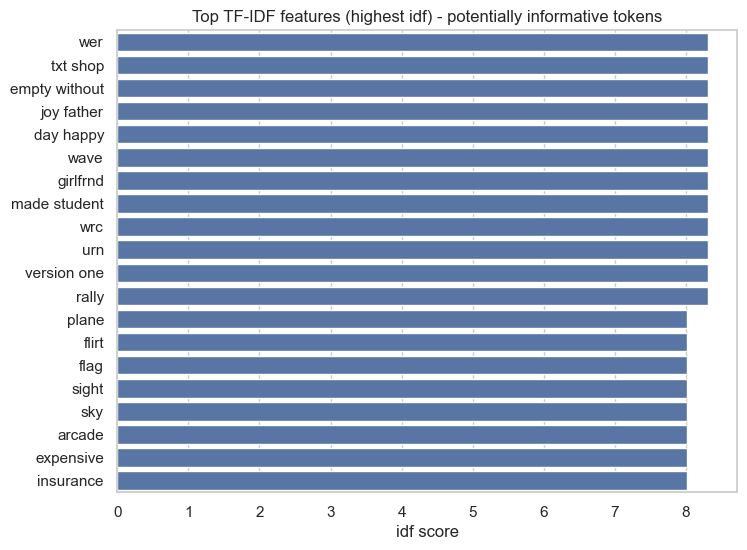

In [10]:

# 8) Visualize top TF-IDF words (by idf)
try:
    feature_names = np.array(tfidf.get_feature_names_out())
    topn = 20
    top_idf_idx = np.argsort(tfidf.idf_)[-topn:][::-1]
    top_features = feature_names[top_idf_idx]
    top_scores = tfidf.idf_[top_idf_idx]
    plt.figure(figsize=(8,6))
    sns.barplot(x=top_scores, y=top_features)
    plt.title('Top TF-IDF features (highest idf) - potentially informative tokens')
    plt.xlabel('idf score')
    plt.show()
except Exception as e:
    print('TF-IDF feature plot failed:', e)


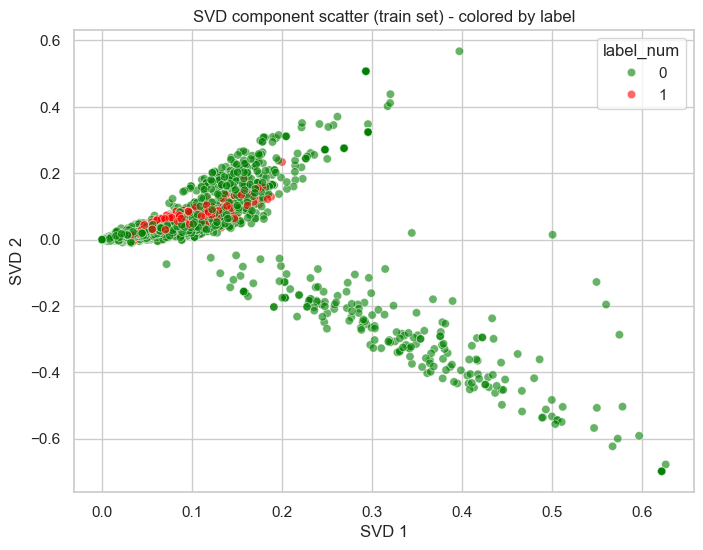

In [11]:

# 9) SVD visualization (train)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_train_svd[:,0], y=X_train_svd[:,1], hue=y_train, palette=['green','red'], alpha=0.6)
plt.title('SVD component scatter (train set) - colored by label')
plt.xlabel('SVD 1'); plt.ylabel('SVD 2'); plt.show()


In [12]:

# 10) Define models and parameter grids 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

models = {
    'LogisticRegression': LogisticRegression(solver='liblinear', class_weight='balanced', random_state=RANDOM_STATE),
    'LinearSVC': LinearSVC(class_weight='balanced', random_state=RANDOM_STATE),
    'RandomForest': RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=RANDOM_STATE),
    'KNN': KNeighborsClassifier(),
    'GradientBoosting': GradientBoostingClassifier(random_state=RANDOM_STATE)
}
if _HAS_XGB:
    models['XGBoost'] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)

param_grids = {
    'LogisticRegression': {'C': [0.01, 0.1, 1, 10]},
    'LinearSVC': {'C': [0.1, 1, 10]},
    'RandomForest': {'n_estimators': [100,200], 'max_depth':[None,10]}
}
if _HAS_XGB:
    param_grids['XGBoost'] = {'n_estimators':[100,200], 'learning_rate':[0.01, 0.1]}


In [13]:

# 11) Train models with GridSearchCV where a grid is provided. Evaluate on test set.
results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

for name, clf in models.items():
    print('\nTraining model:', name)
    if name in param_grids:
        gs = GridSearchCV(clf, param_grids[name], cv=cv, scoring='f1', n_jobs=-1, verbose=0, error_score='raise')
        gs.fit(X_train_feats, y_train)
        best = gs.best_estimator_
        print('Best params:', gs.best_params_)
    else:
        best = clf
        best.fit(X_train_feats, y_train)
    # evaluate on test set
    y_pred = best.predict(X_test_feats)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f'Test Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}')
    results[name] = {'model': best, 'metrics': {'accuracy':acc, 'precision':prec, 'recall':rec, 'f1':f1}}
    # save model artifact
    import joblib
    joblib.dump(best, MODELS_DIR / f'{name}_model.joblib')



Training model: LogisticRegression
Best params: {'C': 10}
Test Acc: 0.9623, Prec: 0.8129, Rec: 0.9329, F1: 0.8688

Training model: LinearSVC
Best params: {'C': 1}
Test Acc: 0.9623, Prec: 0.8129, Rec: 0.9329, F1: 0.8688

Training model: RandomForest
Best params: {'max_depth': None, 'n_estimators': 200}
Test Acc: 0.9803, Prec: 0.9774, Rec: 0.8725, F1: 0.9220

Training model: KNN
Test Acc: 0.9453, Prec: 0.8056, Rec: 0.7785, F1: 0.7918

Training model: GradientBoosting
Test Acc: 0.9794, Prec: 0.9500, Rec: 0.8926, F1: 0.9204

Training model: XGBoost
Best params: {'learning_rate': 0.1, 'n_estimators': 200}
Test Acc: 0.9830, Prec: 0.9577, Rec: 0.9128, F1: 0.9347


                model  accuracy  precision    recall        f1
0             XGBoost  0.982960   0.957746  0.912752  0.934708
1        RandomForest  0.980269   0.977444  0.872483  0.921986
2    GradientBoosting  0.979372   0.950000  0.892617  0.920415
3  LogisticRegression  0.962332   0.812865  0.932886  0.868750
4           LinearSVC  0.962332   0.812865  0.932886  0.868750
5                 KNN  0.945291   0.805556  0.778523  0.791809


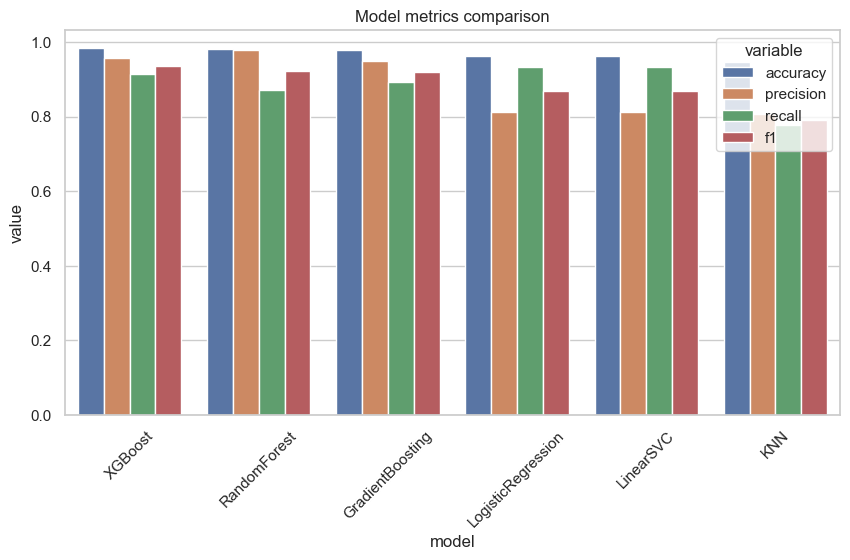

In [14]:

# 12) Compare models
rows = []
for name, info in results.items():
    m = info['metrics']
    rows.append({'model':name, 'accuracy':m['accuracy'], 'precision':m['precision'], 'recall':m['recall'], 'f1':m['f1']})
res_df = pd.DataFrame(rows).sort_values('f1', ascending=False).reset_index(drop=True)
print(res_df)
plt.figure(figsize=(10,5))
sns.barplot(data=res_df.melt(id_vars='model', value_vars=['accuracy','precision','recall','f1']), x='model', y='value', hue='variable')
plt.title('Model metrics comparison'); plt.xticks(rotation=45); plt.show()


Selected best model: XGBoost with F1: 0.9347079037800687
Applying SMOTE to training features and retraining the best model...
Resampled train shape: (7718, 57) (7718,)

Evaluation of best model after SMOTE:
              precision    recall  f1-score   support

         ham       0.99      0.98      0.99       966
        spam       0.90      0.92      0.91       149

    accuracy                           0.97      1115
   macro avg       0.94      0.95      0.95      1115
weighted avg       0.98      0.97      0.98      1115



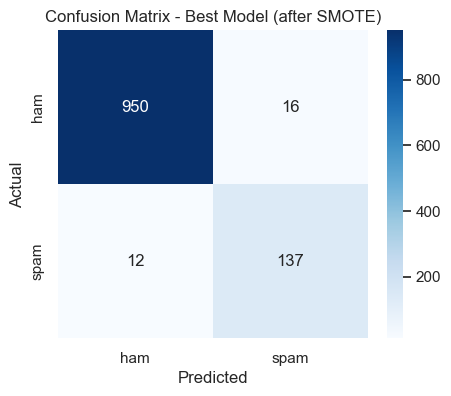

In [15]:

# 13) Select best model by F1 and apply SMOTE only for retraining
best_name = res_df.loc[0,'model']
best_entry = results[best_name]
print('Selected best model:', best_name, 'with F1:', best_entry['metrics']['f1'])

best_model = best_entry['model']

if not _HAS_SMOTE:
    print('imblearn not available. Install imbalanced-learn to use SMOTE (pip install imbalanced-learn)')
else:
    print('Applying SMOTE to training features and retraining the best model...')
    smote = SMOTE(random_state=RANDOM_STATE)
    X_train_sm, y_train_sm = smote.fit_resample(X_train_feats, y_train)
    print('Resampled train shape:', X_train_sm.shape, y_train_sm.shape)
    best_model.fit(X_train_sm, y_train_sm)
    # evaluate on original test set
    y_pred_sm = best_model.predict(X_test_feats)
    print('\nEvaluation of best model after SMOTE:')
    print(classification_report(y_test, y_pred_sm, target_names=le.inverse_transform([0,1])))
    cm = confusion_matrix(y_test, y_pred_sm)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.inverse_transform([0,1]), yticklabels=le.inverse_transform([0,1]))
    plt.title('Confusion Matrix - Best Model (after SMOTE)'); plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()


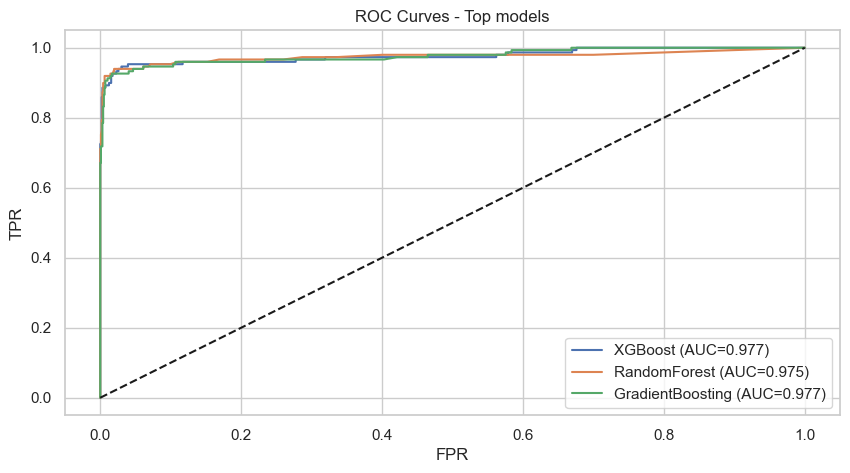

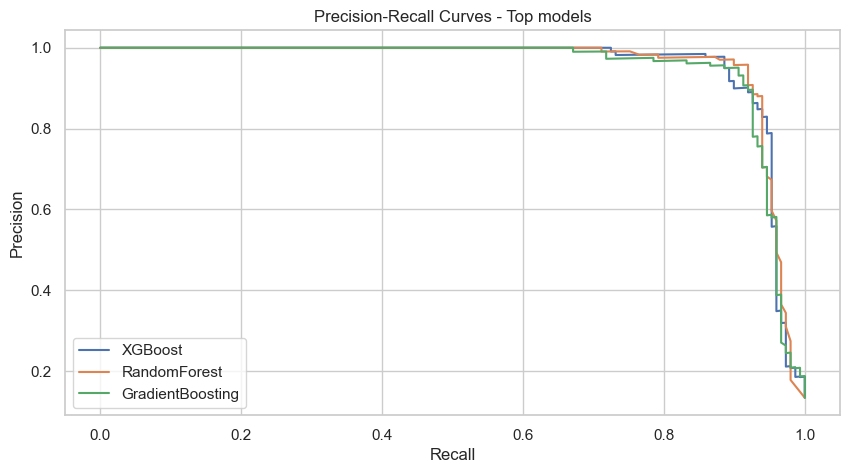

In [16]:

# 14) ROC and Precision-Recall curves for top 3 models
top_models = res_df['model'].tolist()[:3]
plt.figure(figsize=(10,5))
for name in top_models:
    model = results[name]['model']
    try:
        if hasattr(model, 'predict_proba'):
            scores = model.predict_proba(X_test_feats)[:,1]
        elif hasattr(model, 'decision_function'):
            scores = model.decision_function(X_test_feats)
        else:
            print('No probability or decision function for', name)
            continue
        fpr, tpr, _ = roc_curve(y_test, scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.3f})')
    except Exception as e:
        print('ROC failed for', name, e)
plt.plot([0,1],[0,1],'k--')
plt.title('ROC Curves - Top models'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.show()

plt.figure(figsize=(10,5))
for name in top_models:
    model = results[name]['model']
    try:
        if hasattr(model, 'predict_proba'):
            scores = model.predict_proba(X_test_feats)[:,1]
        elif hasattr(model, 'decision_function'):
            scores = model.decision_function(X_test_feats)
        else:
            continue
        prec, rec, _ = precision_recall_curve(y_test, scores)
        plt.plot(rec, prec, label=name)
    except Exception as e:
        print('PR failed for', name, e)
plt.title('Precision-Recall Curves - Top models'); plt.xlabel('Recall'); plt.ylabel('Precision'); plt.legend(); plt.show()


In [17]:

# 15) Save final artifacts: best model, tfidf, svd, kmeans, enc, label encoder
import joblib
artifact = {
    'best_model_name': best_name,
    'best_model': best_model,
    'tfidf': tfidf,
    'svd': svd,
    'kmeans': kmeans,
    'onehot_enc': enc,
    'label_encoder': le
}
joblib.dump(artifact, MODELS_DIR / f'final_artifact_{best_name}.joblib')
print('Saved final artifact for', best_name, 'to models/ directory.')


Saved final artifact for XGBoost to models/ directory.


Best model: XGBoost


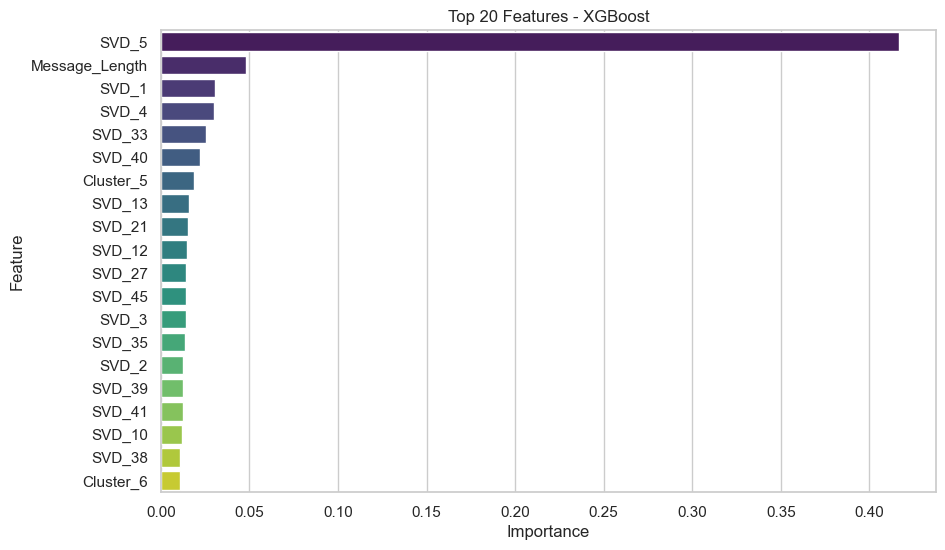

In [22]:
# Identify best model
best_model_name = max(results.items(), key=lambda x: x[1]['metrics']['f1'])[0]
best_model = results[best_model_name]['model']
print(f"Best model: {best_model_name}")


svd_feature_names = [f"SVD_{i+1}" for i in range(X_train_svd.shape[1])]
cluster_feature_names = [f"Cluster_{i+1}" for i in range(cluster_train_oh.shape[1])]
extra_features = ["Message_Length"]

feature_names = svd_feature_names + cluster_feature_names + extra_features

# Get feature importances
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
elif hasattr(best_model, "coef_"):
    importances = np.abs(best_model.coef_[0])
else:
    raise ValueError(f"Model {best_model_name} does not support feature importance.")

# Sanity check
if len(feature_names) != len(importances):
    raise ValueError(f"Feature name count ({len(feature_names)}) != importances count ({len(importances)})")

# Create DataFrame of top 20 features
fi_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=fi_df, palette='viridis')
plt.title(f"Top 20 Features - {best_model_name}")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [23]:
import numpy as np

# Function to get top words for each SVD component
def top_words_for_svd(svd_model, tfidf_vectorizer, component_index, top_n=10):
    terms = np.array(tfidf_vectorizer.get_feature_names_out())
    component_weights = svd_model.components_[component_index]
    top_indices = component_weights.argsort()[::-1][:top_n]
    return terms[top_indices], component_weights[top_indices]

# Example: interpret top features from XGBoost importance chart
top_svd_features = ['SVD_5', 'SVD_1', 'SVD_4']  #from the plot above

for feat in top_svd_features:
    idx = int(feat.split('_')[1]) - 1 
    words, weights = top_words_for_svd(svd, tfidf, idx, top_n=10)
    print(f"\nTop words for {feat}:")
    for w, wt in zip(words, weights):
        print(f"  {w}: {wt:.4f}")



Top words for SVD_5:
  call: 0.3824
  free: 0.2622
  text: 0.1481
  please: 0.1403
  please call: 0.1231
  mobile: 0.1223
  message: 0.1197
  claim: 0.1046
  phone: 0.0996
  txt: 0.0944

Top words for SVD_1:
  gt: 0.3663
  lt: 0.3649
  lt gt: 0.3461
  ok: 0.2931
  call: 0.2688
  get: 0.1539
  later: 0.1391
  sorry: 0.1356
  got: 0.1148
  come: 0.1130

Top words for SVD_4:
  ok: 0.3837
  call later: 0.2250
  later: 0.2244
  sorry call: 0.2044
  sorry: 0.2030
  call: 0.1915
  gt: 0.1477
  lt: 0.1467
  lt gt: 0.1444
  meeting: 0.0475
